In [1]:
#Import the necessary modules

import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR

## Loading the data into the pandas dataframe

In [2]:
df=pd.read_csv("eth_1D.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'})
df=df.set_index("timestamp")

## visualization of the final target 

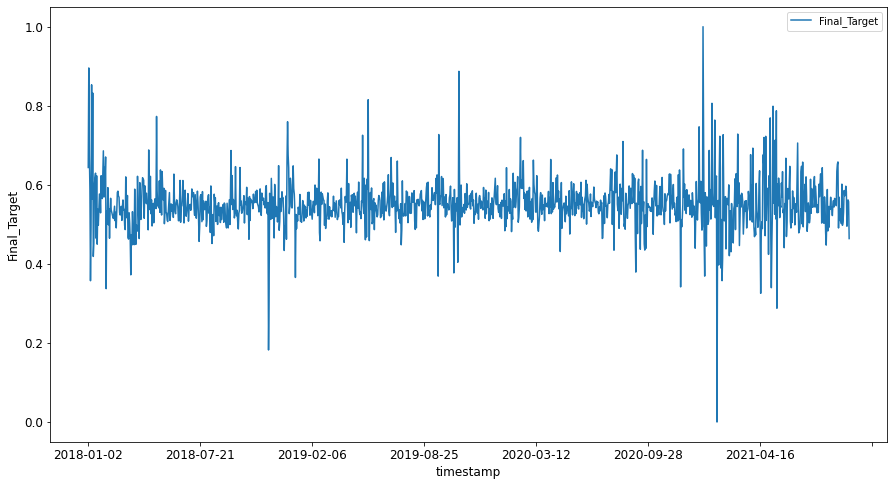

In [3]:
df.plot(y='Final_Target', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.show()

In [4]:
# univariate data: Final_Target vs Time

uni_data_df = df['Final_Target']
uni_data_df.head()
uni_data_df.shape

(1360,)

In [5]:
uni_data_df.shape

(1360,)

In [6]:
train_start_dt = '2018-01-02'
test_start_dt = '2020-08-11'

## Data visualisation of train and test 

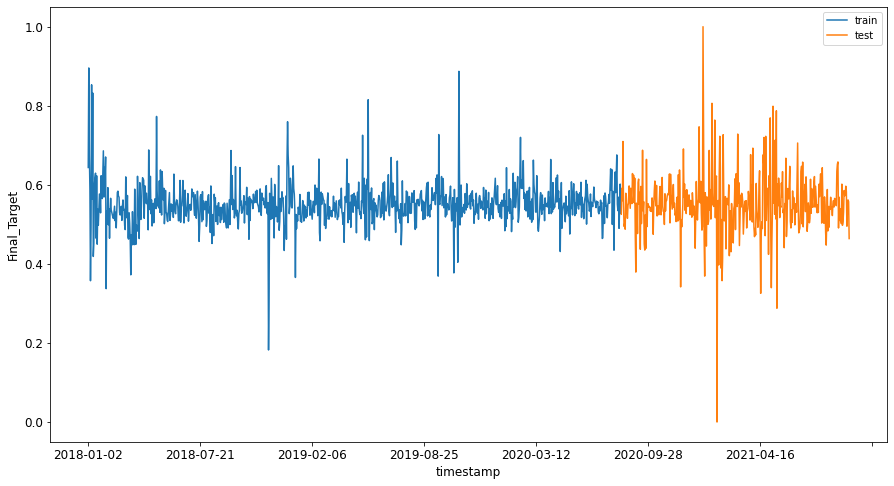

In [7]:
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Final_Target']].rename(columns={'Final_Target':'train'}) \
    .join(df[test_start_dt:][['Final_Target']].rename(columns={'Final_Target':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.show()

In [8]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Final_Target']]
test = df.copy()[df.index >= test_start_dt][['Final_Target']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (952, 1)
Test data shape:  (408, 1)


In [9]:
train.head(10)

,Final_Target
timestamp,
2018-01-02,0.643898
2018-01-03,0.895602
2018-01-04,0.674273
2018-01-05,0.587664
2018-01-06,0.357411
2018-01-07,0.492080
2018-01-08,0.853036
2018-01-09,0.564154
2018-01-10,0.832306


In [10]:
test.shape

(408, 1)

In [11]:
test.head(10)

,Final_Target
timestamp,
2020-08-11,0.525519
2020-08-12,0.591232
2020-08-13,0.559901
2020-08-14,0.709653
2020-08-15,0.549529
2020-08-16,0.494884
2020-08-17,0.501992
2020-08-18,0.487731
2020-08-19,0.578665


In [12]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [13]:
timesteps=5

In [14]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(948, 5)

In [15]:
train_data_timesteps

array([[0.6438976 , 0.89560173, 0.67427336, 0.58766381, 0.35741104],
       [0.89560173, 0.67427336, 0.58766381, 0.35741104, 0.49208042],
       [0.67427336, 0.58766381, 0.35741104, 0.49208042, 0.85303592],
       ...,
       [0.55111854, 0.53464108, 0.56860834, 0.48989827, 0.53837988],
       [0.53464108, 0.56860834, 0.48989827, 0.53837988, 0.60186585],
       [0.56860834, 0.48989827, 0.53837988, 0.60186585, 0.52852349]])

In [16]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(404, 5)

In [17]:
test_data_timesteps

array([[0.52551917, 0.59123209, 0.559901  , 0.70965285, 0.54952946],
       [0.59123209, 0.559901  , 0.70965285, 0.54952946, 0.49488413],
       [0.559901  , 0.70965285, 0.54952946, 0.49488413, 0.50199193],
       ...,
       [0.59656814, 0.58310972, 0.49532802, 0.54084929, 0.56185012],
       [0.58310972, 0.49532802, 0.54084929, 0.56185012, 0.55717008],
       [0.49532802, 0.54084929, 0.56185012, 0.55717008, 0.46407055]])

In [18]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(948, 4) (948, 1)
(404, 4) (404, 1)


In [19]:
x_train,y_train

(array([[0.6438976 , 0.89560173, 0.67427336, 0.58766381],
        [0.89560173, 0.67427336, 0.58766381, 0.35741104],
        [0.67427336, 0.58766381, 0.35741104, 0.49208042],
        ...,
        [0.55111854, 0.53464108, 0.56860834, 0.48989827],
        [0.53464108, 0.56860834, 0.48989827, 0.53837988],
        [0.56860834, 0.48989827, 0.53837988, 0.60186585]]),
 array([[0.35741104],
        [0.49208042],
        [0.85303592],
        [0.56415416],
        [0.83230641],
        [0.41885073],
        [0.45237046],
        [0.59956653],
        [0.6180436 ],
        [0.62952654],
        [0.4649851 ],
        [0.62288243],
        [0.44987078],
        [0.53825222],
        [0.49785711],
        [0.53451967],
        [0.5767268 ],
        [0.57509974],
        [0.52911069],
        [0.62302001],
        [0.56892121],
        [0.56527228],
        [0.62911961],
        [0.68601766],
        [0.56902598],
        [0.64391276],
        [0.61376116],
        [0.67045604],
        [0.33734643],

In [20]:
x_test, y_test

(array([[0.52551917, 0.59123209, 0.559901  , 0.70965285],
        [0.59123209, 0.559901  , 0.70965285, 0.54952946],
        [0.559901  , 0.70965285, 0.54952946, 0.49488413],
        ...,
        [0.59656814, 0.58310972, 0.49532802, 0.54084929],
        [0.58310972, 0.49532802, 0.54084929, 0.56185012],
        [0.49532802, 0.54084929, 0.56185012, 0.55717008]]),
 array([[0.54952946],
        [0.49488413],
        [0.50199193],
        [0.48773059],
        [0.57866486],
        [0.57241112],
        [0.53265718],
        [0.51523144],
        [0.54792786],
        [0.55463368],
        [0.59723388],
        [0.56683646],
        [0.54061806],
        [0.59154753],
        [0.56933108],
        [0.5525001 ],
        [0.62851255],
        [0.59822126],
        [0.62426842],
        [0.55475512],
        [0.61675009],
        [0.47316437],
        [0.37928207],
        [0.55359187],
        [0.5452862 ],
        [0.4767165 ],
        [0.60516385],
        [0.61449676],
        [0.550711  ],

## Model Training

In [21]:
model = SVR(kernel='rbf',gamma=0.05, C=100000,epsilon= 0.05)

In [22]:
model.fit(x_train, y_train[:,0])

SVR(C=100000, epsilon=0.05, gamma=0.05)

In [23]:
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [24]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(948, 1) (404, 1)


In [25]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

948 404


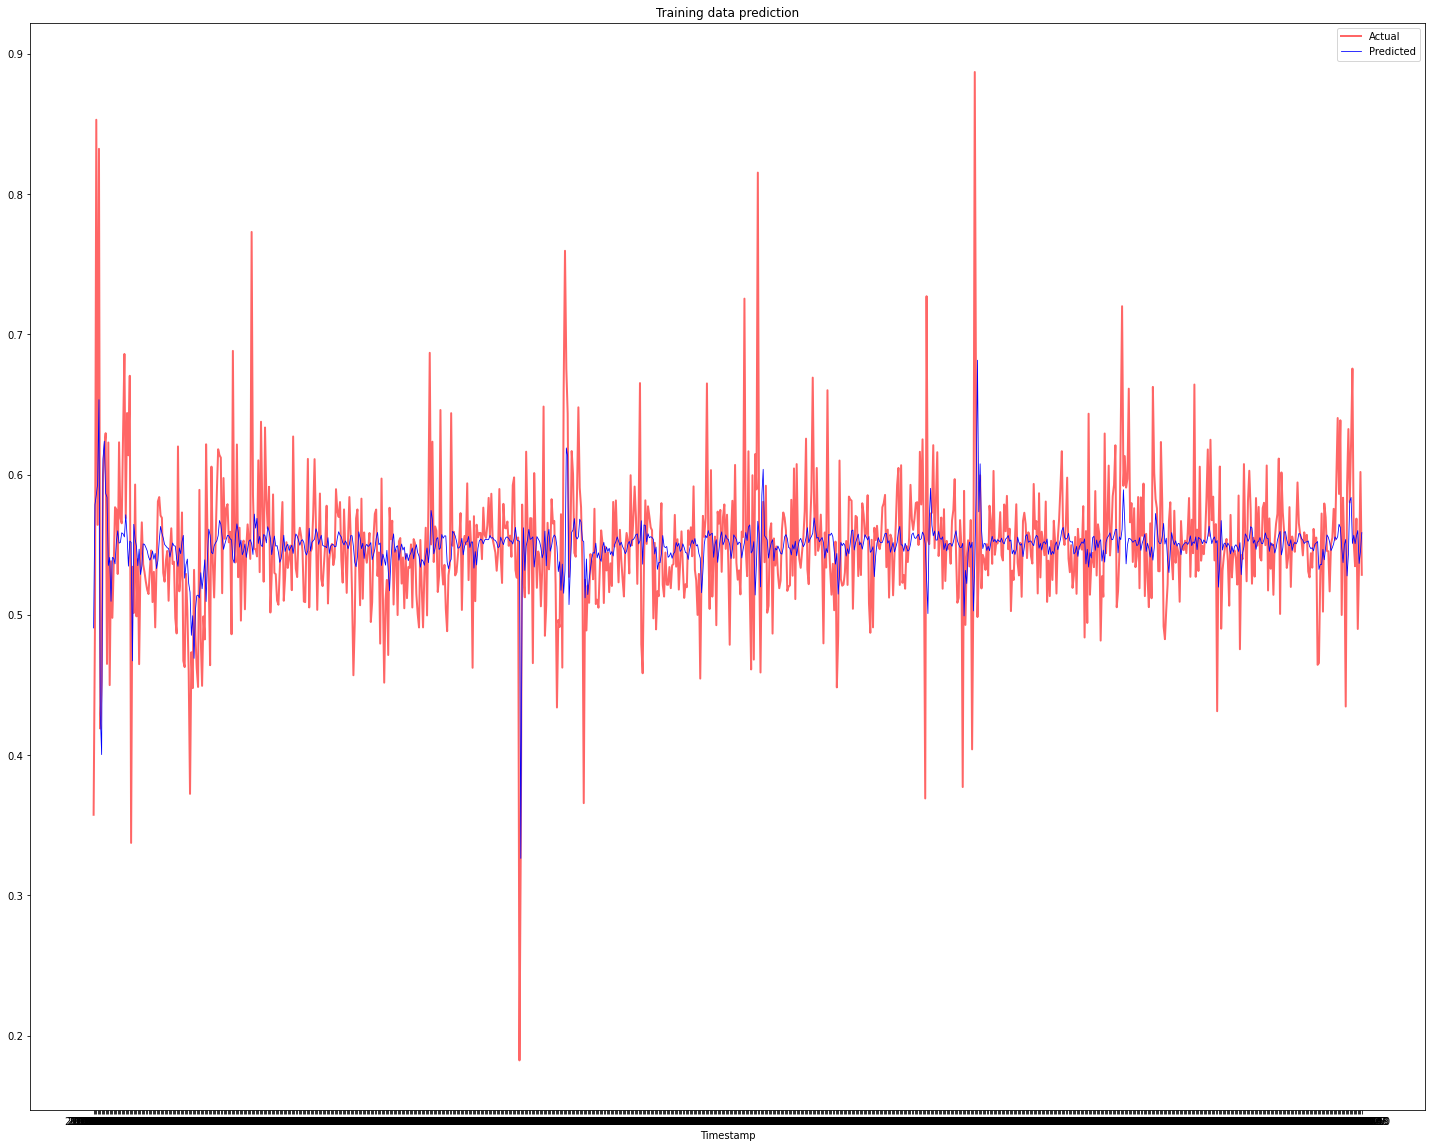

In [26]:
plt.figure(figsize=(25,20))
plt.plot(train_timestamps[:], y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps[:], y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [27]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [28]:
#Test MAPE
mean_absolute_percentage_error1(y_test,y_test_pred)

10.018996069206127

In [29]:
# Train MAPE
mean_absolute_percentage_error1(y_train,y_train_pred)

6.032677052719726

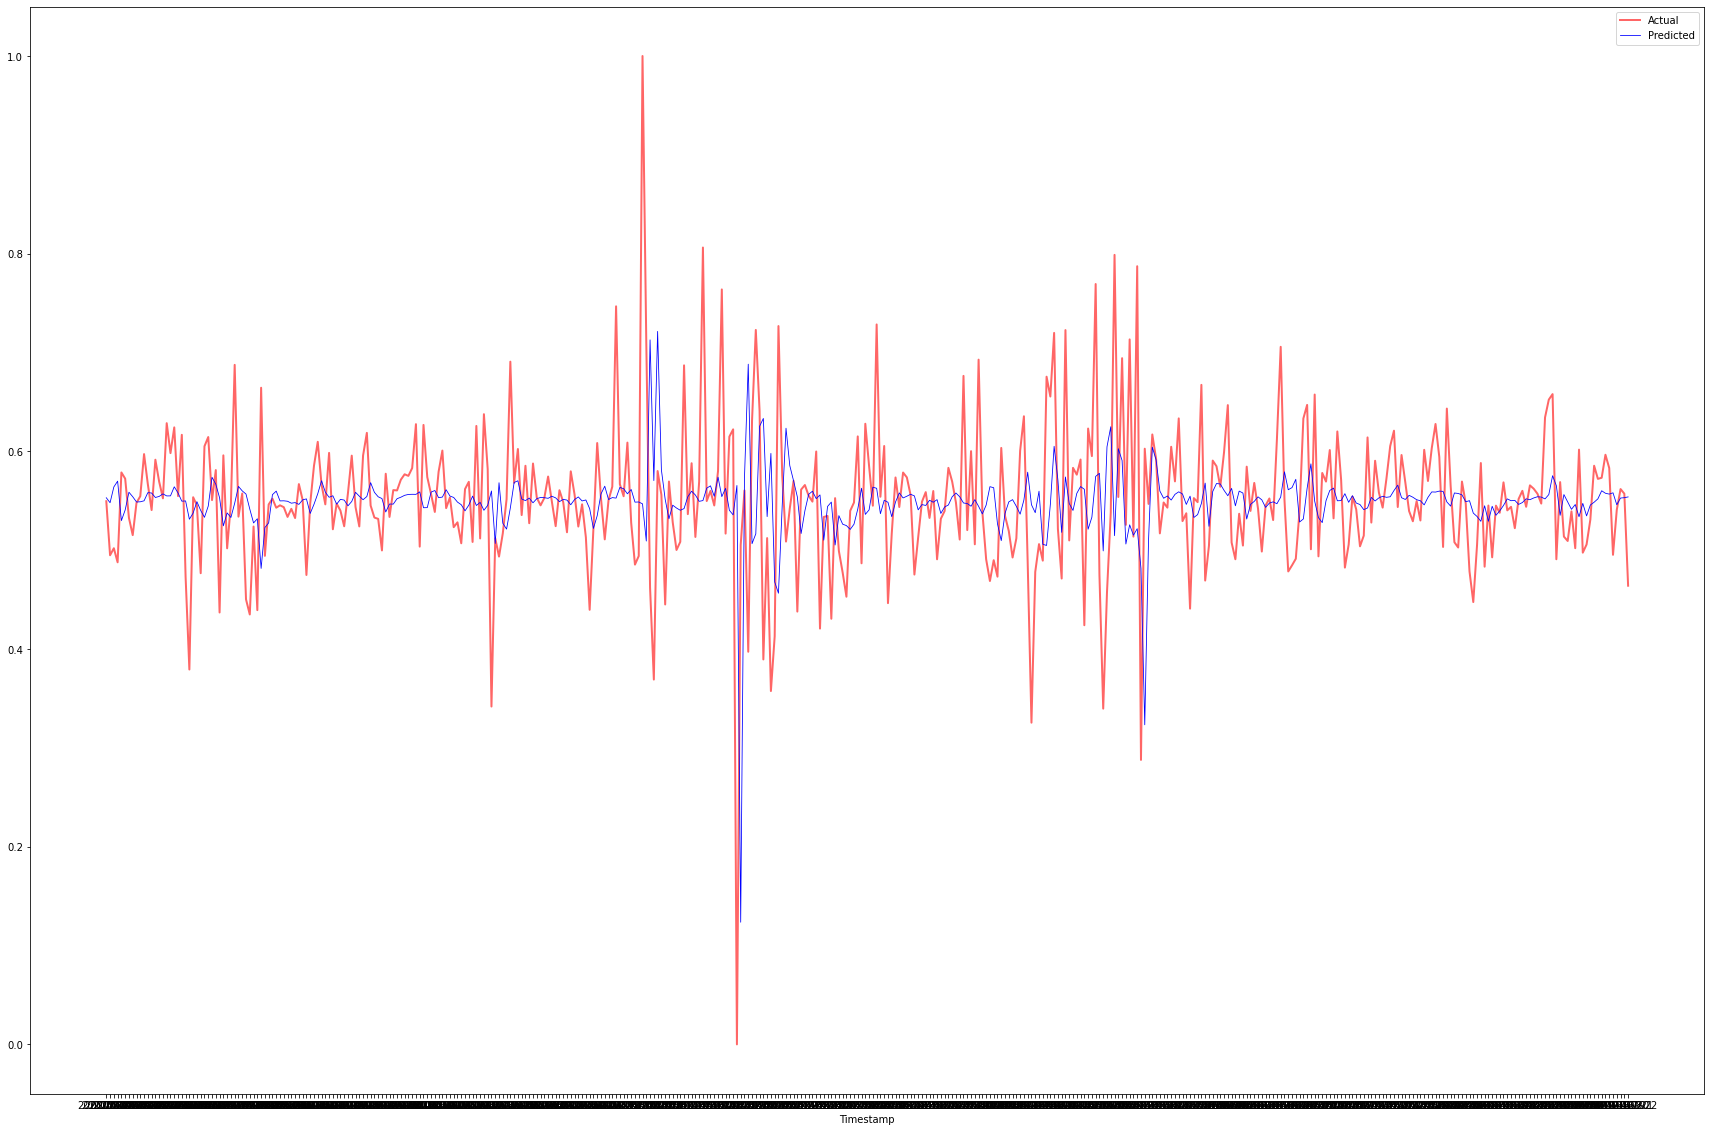

In [30]:
plt.figure(figsize=(30,20))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [31]:
mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.007245172473610607
RMSE: 0.08511857889797389


In [32]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.0023527123363915954
RMSE: 0.048504766120367956
